# pH-rate Profile for Esters

In wqater esters have three possible routes to hydrolysis. 

1. Water attacks the carbonyl group of the ester.
2. Acid catalysis: Water attacks the protonated carbonyl group of the ester.
3. Base catalysis: Hydroxide attacks the carbonyl group of the ester

Let us explore analyzing data for ester hydrolysios

This workbook contains the code and imports the data from multiple files and fits the data to the model..

The data being plotted is from "The Hydrolysis of Diclofenac Esters: Synthetic Prodrug Building Blocks for Biodegradable Drug–Polymer Conjugates." Feng Wang, Joshua Finnin et al., *J. Pharm. Sci.*, **2016**, *105*, 773-785.  https://doi.org/10.1002/jps.24665

The data is found in tables within the supplementary material at https://ars.els-cdn.com/content/image/1-s2.0-S0022354915001550-mmc1.docx


## Setup Tools and Read Data Table

Here the data table is read in and processed. Also the libraries are imported and any functions defined

In [108]:
### SETUP

!pip install uncertainties
!pip install lmfit
!mkdir plots

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.optimize import curve_fit

import uncertainties as un
from uncertainties import unumpy as unp

import lmfit

github_location = "https://raw.githubusercontent.com/blinkletter/4410PythonNotebooks/main/Class_19/data/"
github_location = "data/"
github_location_styles = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/styles/"
github_location_LFER_tables = "https://raw.githubusercontent.com/blinkletter/LFER-QSAR/main/data/"



mkdir: plots: File exists


## Read Data

Read the data in from the csv text file.

In [109]:
### READ DATA

data_file = "4_4.csv"   # 4_1,2,3,4,5 and 9 available

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

display(df)


,pH,log(k /s)
0,0.142276,-5.187713
1,0.256098,-5.160410
2,0.455285,-5.174061
3,0.853659,-4.914676
4,1.166667,-4.709898
5,1.451220,-4.587031
6,1.849593,-4.245734
7,2.162602,-3.959044
8,2.504065,-3.604096
9,3.044715,-3.522184


## Plot Data

This code will quickly plot the data. We idenify the columns we want to use for $x$ and $y$ and then call the plot function.

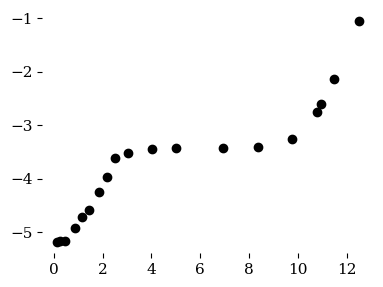

In [110]:
x = df["pH"]
#y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)
y = df["log(k /s)"]

plt.plot(x,y, "ko")
plt.show()


## Fit To a Model

Modify the code below to use a model and get best-fit parameters for your data.

/opt/anaconda3/envs/main/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(7.8519+/-1.0509)e-06
(1.0185+/-0.0791)e+00
(3.1889+/-0.3349)e-03
(3.8420+/-0.2367)e-04


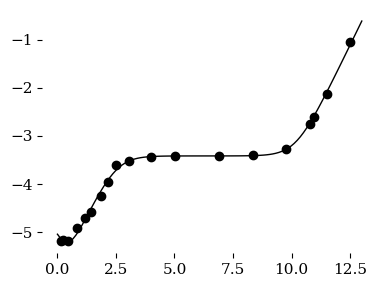

In [111]:
#######################################################
### DEFINE FUNCTIONS FOR EACH MODEL
#######################################################

def line1(x, int):
    ### slope set to -1. We are fitting only for the intercept.
    y = x * -1 + int
    return y

def line2(x, int):
    ### slope set to +1. We are fitting only for the intercept.
    y = x * 1 + int
    return y

def model2(pH, kHKa, kOH):
    ### Two parameter model for acid and base catalysis
    H = 10**(-pH)
    Kw = 10**-13.621
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2
    return np.log10(kobs)
     
def model3(pH, kHKa, kH2O, kOH):
    ### Three parameter model for acid and base catalysis plus water rate
    H = 10**(-pH)
    Kw = 10**-13.621
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

def model4(pH, kHKa1, kH2O, kOH, Ka2, kGB):
    ### Three parameter model for acid and base catalysis plus water rate
    H = 10**(-pH)
    Kw = 10**-13.621
    k1 = kHKa1 * H
    k2 = kOH * Kw/H
    fracA = Ka2/(Ka2 + H)
    kobs = k1  + kH2O + k2*fracA + kGB*fracA
    return np.log10(kobs)

def model4a(pH, kHKa1, kOH, Ka2, kGB):
    ### Three parameter model for acid and base catalysis plus water rate
    H = 10**(-pH)
    Kw = 10**-13.621
    k1 = kHKa1 * H
    k2 = kOH * Kw/H
    fracA = Ka2/(Ka2 + H)
    kobs = k1  + k2*fracA + kGB*fracA
    return np.log10(kobs)

def model4b(pH, kOH, Ka2, kGB):
    ### Three parameter model for acid and base catalysis plus water rate
    H = 10**(-pH)
    Kw = 10**-13.621
    k2 = kOH * Kw/H
    fracA = Ka2/(Ka2 + H)
    kobs = k2*fracA + kGB*fracA
    return np.log10(kobs)


### READ DATA

data_file = "4_4.csv"   # 4_1,2,3,4,5 and 9 available

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

#######################################################
### PLOT DATA
#######################################################
x = df["pH"]
# y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)
y = df["log(k /s)"]
plt.plot(x,y, "ko")

m = model4a

#######################################################
### FIT DATA TO MODEL
#######################################################

popt,pcov = curve_fit(m, x, y,
  #                   p0 = [100,1E-2,0.1],    # for model4b
                     p0 = [1E-6,100,1E-2,0.1],    # for model4a
   #                  p0 = [1E-6,1E-12,100,1E-2,0.1],    # for model4
                    )

#######################################################
### COLLECT RESULTS AND PRINT
#######################################################

popt_uncertain = un.correlated_values(popt,pcov)

for p in popt_uncertain:    # print all results from curve fit
    print(f"{p:0.4e}")

#######################################################
### Plot BEST FIT LINE
#######################################################

x1 = np.linspace(0,13,100)  # make 100 points between 1 and 8 for x-axis
y1 = m(x1, *popt)     # calculate y values for those 100 x values

plt.plot(x1, y1)           # plot the calculated line
plt.show()

[[Model]]
    Model(model4a)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 19
    # variables        = 4
    chi-square         = 0.05570555
    reduced chi-square = 0.00371370
    Akaike info crit   = -102.810175
    Bayesian info crit = -99.0324190
    R-squared          = 0.99749808
[[Variables]]
    kHKa1:  7.8519e-06 +/- 1.0509e-06 (13.38%) (init = 1e-06)
    kOH:    1.01851727 +/- 0.07907890 (7.76%) (init = 1)
    Ka2:    0.00318894 +/- 3.3488e-04 (10.50%) (init = 0.001)
    kGB:    3.8420e-04 +/- 2.3670e-05 (6.16%) (init = 0.0001)
[[Correlations]] (unreported correlations are < 0.100)
    C(Ka2, kGB)   = -0.7316
    C(kHKa1, Ka2) = -0.2778
    C(kOH, kGB)   = -0.1316

          99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 kHKa1:  -0.00000  -0.00000  -0.00000   0.00001  +0.00000  +0.00000  +0.00000
 kOH  :  -0.25083  -0.15985  -0.07880   1.01852  +0.08459  +0.18563  +0.32072
 Ka2  :  -0.00100  -0.00

{'kHKa1': 7.851855241991501e-06+/-1.0509391827873601e-06,
 'kOH': 1.0185172705390806+/-0.07907890126037533,
 'Ka2': 0.003188939802442503+/-0.00033487849201876583,
 'kGB': 0.00038420123539872897+/-2.366952241669883e-05}

pKa2 = -2.496+/-0.046


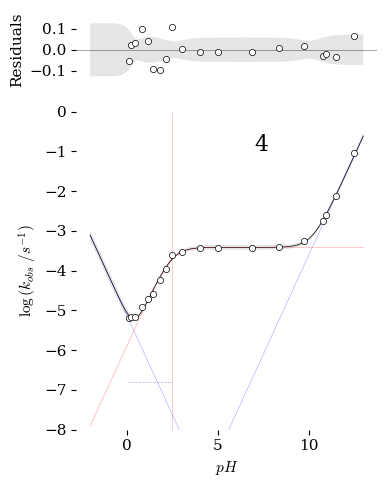

In [112]:
data_file = "4_4.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

 ### Use curve_fit function  

Kw = 10**-13.621

# define the function for the model
def model4a(pH, kHKa1, kOH, Ka2, kGB):
    ### Three parameter model for acid and base catalysis plus water rate
    H = 10**(-pH)
    k1 = kHKa1 * H
    k2 = kOH * Kw/H
    fracA = Ka2/(Ka2 + H)
    kobs = k1  + k2*fracA + kGB*fracA
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(model4a)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kHKa1 = dict(value = 1E-6, min=0), 
                       kOH =  dict(value = 1, min=0),
                       Ka2 = dict(value = 1E-3, min=0), 
                       kGB = dict(value = 1E-4, min=0), 
                      )

x = df["pH"]
#y = np.log10(df["k1 (10-5 hr-1)"] *1E-5)
y = df["log(k /s)"]


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
print(result.fit_report())
print()
print(result.ci_report())
print()
display(result.uvars)

print(f"pKa2 = {unp.log10(result.uvars["Ka2"]):0.3f}")


###############################################################################
### FANCY PLOT OF RESULT
###############################################################################
start = -2
end = 13
x1 = np.linspace(start, end, 100)
y1 = result.eval(pH = x1)
y1_4 = unp.nominal_values(result.eval(pH = x1))    # for final plot
dely = result.eval_uncertainty(pH = x1, sigma=2)   # 95% confidence band

kHKa1 = result.best_values["kHKa1"]
kGB = result.best_values["kGB"]
Ka2 = result.best_values["Ka2"]
kOH = result.best_values["kOH"]

y4_kHKa1 = np.log10(kHKa1 * 10**-x1)
y4_GB = np.log10(Ka2/(Ka2+10**-x1)*kGB)
y4_kOH = np.log10(Ka2/(Ka2+10**-x1)*kOH*Kw / 10**-x1)


size2 = 4,5
###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          title = Title,       
          ylabel=r"$\log{(k_{obs}\ /s^{-1})}$",                
          xlabel=r"$pH$ ", 
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-8,0]
#          xticks = [1,3,5,7],
#          yticks = [0,-1,-2,-3],
       )

### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1].plot(x1,unp.nominal_values(y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)

# Confidence band
fit_up = y1 + dely
fit_dn = y1 - dely
ax[1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -result.residual     

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-.19,.19]
       )
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
# make filled band
ax[0].fill_between(x1, dely, -dely, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


ax[1].text(7,-1,"4", fontsize = "x-large")

ax[1].plot(x1, y4_kHKa1, 
           marker = None, color = "blue", alpha = 0.3,
           linewidth=0.5, zorder = 0)
ax[1].plot(x1, y4_kOH, 
           marker = None, color = "blue", alpha = 0.3, 
           linewidth=0.5, zorder = 0)
ax[1].plot(x1, y4_GB, 
           marker = None, color = "red", alpha = 0.3, 
           linewidth=0.5, zorder = 0)
ax[1].axvline(x = -np.log10(Ka2), color = "red", alpha = 0.3, linewidth=0.5, zorder = 0)

ax[1].hlines(y=-6.8, xmin = 0, xmax = -np.log10(Ka2), color = "blue", alpha = 0.3, 
             linewidth=0.5, linestyle = "--", zorder = 0)

################################################
### Output Plot
################################################

name = "plot4_4"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax[0].patch.set_facecolor([0, 0, 0, 0])  
ax[1].patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()


[[Model]]
    Model(model3)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 13
    # variables        = 3
    chi-square         = 0.02818810
    reduced chi-square = 0.00281881
    Akaike info crit   = -73.7394593
    Bayesian info crit = -72.0446113
    R-squared          = 0.99946089
[[Variables]]
    kHKa:  1.4146e-06 +/- 1.3542e-07 (9.57%) (init = 1e-06)
    kH2O:  6.8496e-08 +/- 4.1657e-09 (6.08%) (init = 1e-08)
    kOH:   1.31926959 +/- 0.07281139 (5.52%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kHKa, kH2O) = -0.2405

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 kHKa:  -0.00000  -0.00000  -0.00000   0.00000  +0.00000  +0.00000  +0.00000
 kH2O:  -0.00000  -0.00000  -0.00000   0.00000  +0.00000  +0.00000  +0.00000
 kOH :  -0.26022  -0.15689  -0.07470   1.31927  +0.07903  +0.17730  +0.32163



{'kHKa': 1.4145716575875156e-06+/-1.3541679941432276e-07,
 'kH2O': 6.849562073085735e-08+/-4.1656519757347475e-09,
 'kOH': 1.3192695864944977+/-0.07281138934223547}

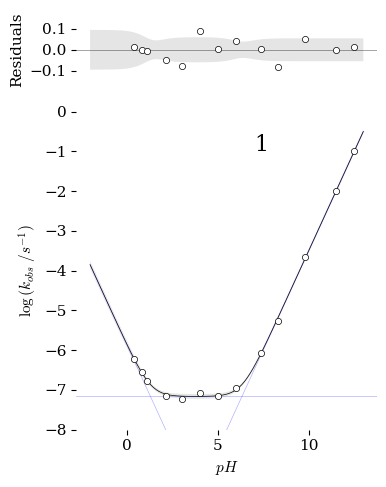

In [113]:
data_file = "4_1.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

 ### Use curve_fit function  

Kw = 10**-13.621

# define the function for the model
def model2(pH, kHKa, kOH):
    ### Two parameter model for acid and base catalysis
    H = 10**(-pH)
    Kw = 10**-13.621
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2
    return np.log10(kobs)
     
def model3(pH, kHKa, kH2O, kOH):
    ### Three parameter model for acid and base catalysis plus water rate
    H = 10**(-pH)
    Kw = 10**-13.621
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(model3)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kHKa = dict(value = 1E-6, min=0), 
                       kH2O =  dict(value = 1E-8, min=0),
                       kOH =  dict(value = 1, min=0),
                      )

x = df["pH"]
y = df["log(k /s)"]


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
print(result.fit_report())
print()
print(result.ci_report())
print()
display(result.uvars)



###############################################################################
### FANCY PLOT OF RESULT
###############################################################################

x1 = np.linspace(start, end, 100)
y1 = result.eval(pH = x1)
y1_1 = unp.nominal_values(result.eval(pH = x1))    # for final plot

dely = result.eval_uncertainty(pH = x1, sigma=2)   # 95% confidence band

kHKa = result.best_values["kHKa"]
kH2O = result.best_values["kH2O"]
kOH = result.best_values["kOH"]

y1_kHKa = np.log10(kHKa * 10**-x1)
y1_kH2O = np.log10(kH2O)
y1_kOH = np.log10(kOH*Kw / 10**-x1)


size2 = 4,5
###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          title = Title,       
          ylabel=r"$\log{(k_{obs}\ /s^{-1})}$",                
          xlabel=r"$pH$ ", 
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-8,0]
#          xticks = [1,3,5,7],
#          yticks = [0,-1,-2,-3],
       )

### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1].plot(x1,unp.nominal_values(y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)

# Confidence band
fit_up = y1 + dely
fit_dn = y1 - dely
ax[1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -result.residual     

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-.19,.19]
       )
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
# make filled band
ax[0].fill_between(x1, dely, -dely, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


ax[1].text(7,-1,"1", fontsize = "x-large")



ax[1].plot(x1, y1_kHKa, 
           marker = None, color = "blue", alpha = 0.3,
           linewidth=0.5, zorder = 0)
ax[1].plot(x1, y1_kOH, 
           marker = None, color = "blue", alpha = 0.3, 
           linewidth=0.5, zorder = 0)
ax[1].axhline(y=y1_kH2O, color = "blue", alpha = 0.3, linewidth=0.5, zorder = 0)


################################################
### Output Plot
################################################

name = "plot4_1"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax[0].patch.set_facecolor([0, 0, 0, 0])  
ax[1].patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()


[[Model]]
    Model(model3)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 14
    # variables        = 3
    chi-square         = 0.02351990
    reduced chi-square = 0.00213817
    Akaike info crit   = -83.4455195
    Bayesian info crit = -81.5283475
    R-squared          = 0.99966962
[[Variables]]
    kHKa:  1.7561e-06 +/- 1.3927e-07 (7.93%) (init = 1e-06)
    kH2O:  6.5811e-08 +/- 3.1261e-09 (4.75%) (init = 1e-08)
    kOH:   1.02559422 +/- 0.05095450 (4.97%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(kHKa, kH2O) = -0.2056

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 kHKa:  -0.00000  -0.00000  -0.00000   0.00000  +0.00000  +0.00000  +0.00000
 kH2O:  -0.00000  -0.00000  -0.00000   0.00000  +0.00000  +0.00000  +0.00000
 kOH :  -0.17925  -0.10895  -0.05207   1.02559  +0.05472  +0.12124  +0.21514



{'kHKa': 1.7561225154061333e-06+/-1.392660271828534e-07,
 'kH2O': 6.581122291571262e-08+/-3.126060887696959e-09,
 'kOH': 1.0255942249682906+/-0.050954499273821376}

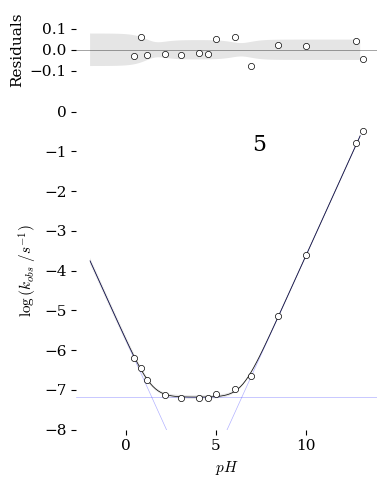

In [114]:
data_file = "4_5.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

 ### Use curve_fit function  

Kw = 10**-13.621

# define the function for the model
def model2(pH, kHKa, kOH):
    ### Two parameter model for acid and base catalysis
    H = 10**(-pH)
    Kw = 10**-13.621
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2
    return np.log10(kobs)
     
def model3(pH, kHKa, kH2O, kOH):
    ### Three parameter model for acid and base catalysis plus water rate
    H = 10**(-pH)
    Kw = 10**-13.621
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(model3)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kHKa = dict(value = 1E-6, min=0), 
                       kH2O =  dict(value = 1E-8, min=0),
                       kOH =  dict(value = 1, min=0),
                      )

x = df["pH"]
y = df["log(k /s)"]


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
print(result.fit_report())
print()
print(result.ci_report())
print()
display(result.uvars)



###############################################################################
### FANCY PLOT OF RESULT
###############################################################################

x1 = np.linspace(start, end, 100)
y1 = result.eval(pH = x1)
y1_5 = unp.nominal_values(result.eval(pH = x1))    # for final plot

dely = result.eval_uncertainty(pH = x1, sigma=2)   # 95% confidence band

kHKa = result.best_values["kHKa"]
kH2O = result.best_values["kH2O"]
kOH = result.best_values["kOH"]

y5_kHKa = np.log10(kHKa * 10**-x1)
y5_kH2O = np.log10(kH2O)
y5_kOH = np.log10(kOH*Kw / 10**-x1)


size2 = 4,5
###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          title = Title,       
          ylabel=r"$\log{(k_{obs}\ /s^{-1})}$",                
          xlabel=r"$pH$ ", 
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-8,0]
#          xticks = [1,3,5,7],
#          yticks = [0,-1,-2,-3],
       )

### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1].plot(x1,unp.nominal_values(y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)

# Confidence band
fit_up = y1 + dely
fit_dn = y1 - dely
ax[1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -result.residual     

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-.19,.19]
       )
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
# make filled band
ax[0].fill_between(x1, dely, -dely, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


ax[1].text(7,-1,"5", fontsize = "x-large")



ax[1].plot(x1, y5_kHKa, 
           marker = None, color = "blue", alpha = 0.3,
           linewidth=0.5, zorder = 0)
ax[1].plot(x1, y5_kOH, 
           marker = None, color = "blue", alpha = 0.3, 
           linewidth=0.5, zorder = 0)
ax[1].axhline(y=y5_kH2O, color = "blue", alpha = 0.3, linewidth=0.5, zorder = 0)


################################################
### Output Plot
################################################

name = "plot4_5"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax[0].patch.set_facecolor([0, 0, 0, 0])  
ax[1].patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()


[[Model]]
    Model(model2a)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 12
    # variables        = 2
    chi-square         = 0.09983591
    reduced chi-square = 0.00998359
    Akaike info crit   = -53.4696080
    Bayesian info crit = -52.4997947
    R-squared          = 0.99700222
[[Variables]]
    kH2O:  1.1805e-05 +/- 9.4355e-07 (7.99%) (init = 0.0001)
    kOH:   12.0607127 +/- 1.56708256 (12.99%) (init = 1)

         99.73%    95.45%    68.27%    _BEST_    68.27%    95.45%    99.73%
 kH2O:  -0.00000  -0.00000  -0.00000   0.00001  +0.00000  +0.00000  +0.00000
 kOH :  -4.91215  -3.13512  -1.55923  12.06071  +1.78271  +4.19190  +8.12212



{'kH2O': 1.180515220200462e-05+/-9.435473267225079e-07,
 'kOH': 12.060712741594624+/-1.5670825608407404}

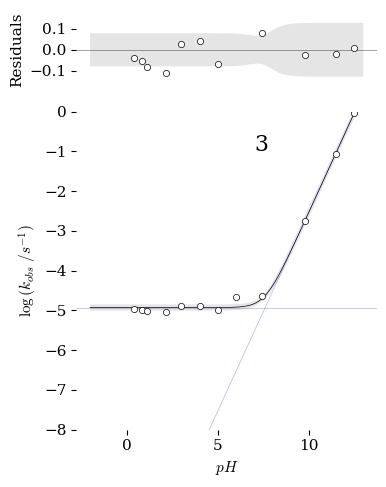

In [115]:
data_file = "4_3.csv"

df = pd.read_csv(github_location + data_file, 
             delimiter = ",", 
             skipinitialspace=True, 
 #            index_col="pH", 
             comment = "#") 

 ### Use curve_fit function  

Kw = 10**-13.621

# define the function for the model
def model2a(pH, kH2O, kOH):
    ### Two parameter model for acid and base catalysis
    H = 10**(-pH)
    k2 = kOH * Kw/H
    kobs = kH2O + k2
    return np.log10(kobs)
     
def model3(pH, kHKa, kH2O, kOH):
    ### Three parameter model for acid and base catalysis plus water rate
    H = 10**(-pH)
    k1 = kHKa * H
    k2 = kOH * Kw/H
    kobs = k1 + k2 + kH2O
    return np.log10(kobs)

# Create a model by loading the function via the lmfit.Model tool
mod = lmfit.Model(model2a)  

# Set parameters - here i also set minimims so that no negative values are encountered in the fit
pars = mod.make_params(kH2O =  dict(value = 1E-4, min=0),
                       kOH =  dict(value = 1, min=0),
                      )

x = df["pH"]
y = df["log(k /s)"]


# use the .fit method on the model object to perform the curve fit
result = mod.fit(y, pars, pH=x)   
print(result.fit_report())
print()
print(result.ci_report())
print()
display(result.uvars)



###############################################################################
### FANCY PLOT OF RESULT
###############################################################################

x1 = np.linspace(start, end, 100)
y1 = result.eval(pH = x1)
dely = result.eval_uncertainty(pH = x1, sigma=2)   # 95% confidence band
y1_3 = unp.nominal_values(result.eval(pH = x1))    # for final plot

kH2O = result.best_values["kH2O"]
kOH = result.best_values["kOH"]

y3_kH2O = np.log10(kH2O)
y3_kOH = np.log10(kOH*Kw / 10**-x1)


size2 = 4,5
###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=size2, height_ratios=[1, 4])  

# Settings for plot
ax[1].set(
#          title = Title,       
          ylabel=r"$\log{(k_{obs}\ /s^{-1})}$",                
          xlabel=r"$pH$ ", 
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-8,0]
#          xticks = [1,3,5,7],
#          yticks = [0,-1,-2,-3],
       )

### Data graphics
ax[1].scatter(x, y, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 4) 

# Plot the curve fit line
ax[1].plot(x1,unp.nominal_values(y1), 
           marker = None, color = "black", 
           linewidth=0.5, zorder = 0)

# Confidence band
fit_up = y1 + dely
fit_dn = y1 - dely
ax[1].fill_between(x1, fit_up, fit_dn, 
                   facecolor="black", alpha=0.1, zorder = 2,
                   label="confidence interval")

######################
### Plot the residuals
######################

# difference between data and line-fit
residuals = -result.residual     

ax[0].set(
#          title = Title,       
          ylabel=r"Residuals", 
          xlabel=r"",                
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-.19,.19]
       )
### Data graphics
ax[0].scatter(x, residuals, marker = "o", s = 20, 
              color = "white", edgecolors = "black", 
              linewidths=0.5, zorder = 3)
# make filled band
ax[0].fill_between(x1, dely, -dely, 
                   facecolor="black", alpha=0.1, zorder = 1,
                   linewidth = 0, label="confidence interval")

### Other elements
ax[0].axhline(0, color='gray', linewidth=0.5, zorder = 0) 
ax[0].set_xticks([])


ax[1].text(7,-1,"3", fontsize = "x-large")



ax[1].plot(x1, y3_kOH, 
           marker = None, color = "blue", alpha = 0.3, 
           linewidth=0.5, zorder = 0)
ax[1].axhline(y=y3_kH2O, color = "blue", alpha = 0.3, linewidth=0.5, zorder = 0)


################################################
### Output Plot
################################################

name = "plot4_3"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax[0].patch.set_facecolor([0, 0, 0, 0])  
ax[1].patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()


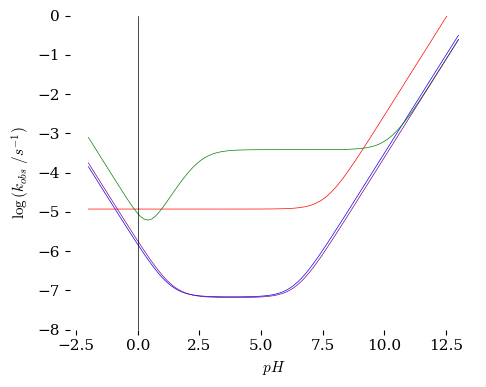

In [120]:


###############################################################################
### FANCY PLOT OF RESULT
###############################################################################

x1 = np.linspace(start, end, 100)


size2 = 5,4
###############################################################################
######################
### Plots - NEW STYLED PLOTTING SECTION
######################

plt.rcdefaults()

style = "tufte.mplstyle"
#style = "S2_classic2.mplstyle"
style_name = github_location_styles + style
plt.style.use(style_name)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size2)  

# Settings for plot
ax.set(
#          title = Title,       
          ylabel=r"$\log{(k_{obs}\ /s^{-1})}$",                
          xlabel=r"$pH$ ", 
#          xlim=[0, np.max(x) + np.max(x) * 0.1],                  
          ylim=[-8,0]
#          xticks = [1,3,5,7],
#          yticks = [0,-1,-2,-3],
       )

ax.plot(x1, y1_1, 
           marker = None, color = "blue", alpha = 1, 
           linewidth=0.5, zorder = 0)

ax.plot(x1, y1_3, 
           marker = None, color = "red", alpha = 1, 
           linewidth=0.5, zorder = 0)

ax.plot(x1, y1_4, 
           marker = None, color = "green", alpha = 1, 
           linewidth=0.5, zorder = 0)

ax.plot(x1, y1_5, 
           marker = None, color = "purple", alpha = 1, 
           linewidth=0.5, zorder = 0)

ax.axvline(x = 0, color = "black", alpha = 1, 
             linewidth=0.5, zorder = 0)

################################################
### Output Plot
################################################

name = "plot4_all"

# Plot as .pdf
plt.savefig(f"plots/{name}.pdf")

### Set face of plot to transparent
ax.patch.set_facecolor([0, 0, 0, 0])  

# Plot as .png with transparent background
plt.savefig(f"plots/{name}.png", dpi=600, 
            facecolor = [0, 0, 0, 0],
        )
# display plot in notebook
plt.show()
